In [23]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# qNParEGO specific
from botorch.acquisition.objective import GenericMCObjective, ConstrainedMCObjective
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.sampling import sample_simplex

# utilities
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.hypervolume import infer_reference_point
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

# pymoo dependencies
import pymoo

from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize

from pymoo.core.problem import Problem as PymooProblem
from pymoo.core.termination import NoTermination
from pymoo.factory import get_performance_indicator

###########

# jmetalpy dependencies
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations, TerminationCriterion
from jmetal.util.aggregative_function import Tschebycheff
from jmetal.operator import PolynomialMutation, DifferentialEvolutionCrossover
from jmetal.algorithm.multiobjective.moead import Permutation
from jmetal.algorithm.multiobjective import MOEAD

###########

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import qmc
from scipy.stats import gaussian_kde # for density plot

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



In [24]:
def optimize_qnehvi_noconstr(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Pure qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts of raw_samples
                        raw_samples=256,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        
        ##########
        
        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [25]:
def optimize_hybrid_nsga_noconstr(problem, ref_point, initial_x, # must haves
                                  N_BATCH, BATCH_SIZE, 
                                  random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + U-NSGA-III")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=0, 
                  xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts of raw_samples
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########

        # we pick out the best points so far to form parents
        pareto_mask = is_non_dominated(train_obj_noisy)
        pareto_y = train_obj_noisy[pareto_mask]
        pareto_x = train_x_gp[pareto_mask]
        
        algorithm = UNSGA3(pop_size=256,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
                           sampling=pareto_x.cpu().numpy(),
                          )

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", pareto_y.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, nsga3_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y)
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x, bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, qnehvi_x, nsga3_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [26]:
def optimize_hybrid_moead_noconstr(problem, ref_point, initial_x, # must haves
                                  N_BATCH, BATCH_SIZE, 
                                  random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + MOEAD")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # define jmetal class
    class jmetalproblem(FloatProblem):

        def __init__(self):
            super(jmetalproblem, self).__init__()
            self.number_of_variables = problem.n_var
            self.number_of_objectives = problem.n_obj

            obj_directions = []
            obj_labels = []

            for i in range(1,problem.n_obj+1):
                obj_directions.append(self.MINIMIZE)
                obj_labels.append(f'f{i}')

            self.obj_directions = obj_directions
            self.obj_labels = obj_labels

            self.lower_bound = [0.0] * problem.n_var
            self.upper_bound = [1.0] * problem.n_var

        def evaluate(self, solution: FloatSolution) -> FloatSolution:
            pass

        def get_name(self):
            return 'jmetalproblem'

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts of raw_samples
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########

        max_pop = train_x_gp.shape[0]
        
        # redefine a new algo at each iteration
        MOEAD_algo = MOEAD(problem=jmetalproblem(),
                          population_size=max_pop,
                          crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5),
                          mutation=PolynomialMutation(probability=1.0 / jmetalproblem().number_of_variables, distribution_index=20),
                          aggregative_function=Tschebycheff(dimension=jmetalproblem().number_of_objectives),
                          neighbor_size=int(max_pop/2),
                          neighbourhood_selection_probability=0.9,
                          max_number_of_replaced_solutions=2,
                          weight_files_path='weights',
                          #termination_criterion=StoppingByEvaluations(BATCH_SIZE),
                         )

        # initialize population
        initial_solutions = []

        for i in range(0, max_pop):
            solution1 = FloatSolution(lower_bound=[0.0] * problem.n_var,
                                      upper_bound=[1.0] * problem.n_var,
                                      number_of_objectives=problem.n_obj,
                                     )
            solution1.variables = train_x_gp[i].cpu().tolist()
            solution1.objectives = train_obj_noisy[i].cpu().tolist()
            
            initial_solutions.append(solution1)

        MOEAD_algo.solutions = initial_solutions

        # perform selection, crossover and mutation to form our offspring population
        MOEAD_algo.permutation = Permutation(max_pop)
        offspring_population = []

        for q in range(256):
            mating_population = MOEAD_algo.selection(MOEAD_algo.solutions)
            offspring = MOEAD_algo.reproduction(mating_population)
            offspring_population.append(offspring[0].variables)
                        
        moead_x = torch.tensor(offspring_population, **tkwargs)        
        
        ##########

        candidates = torch.cat([qnehvi_x, moead_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y)
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x, bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, qnehvi_x, moead_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [27]:
def optimize_parallel_nsga_noconstr(problem, ref_point, initial_x, # must haves
                                    N_BATCH, BATCH_SIZE, 
                                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    if BATCH_SIZE%2 != 0:
        raise Exception("Batch size must be a multiple of 2!")
        
    p_BATCH_SIZE = int(BATCH_SIZE/2)

    print("Optimizing with Parallel qNEHVI + U-NSGA-III")
    
    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    
    # define pymoo problem class
    pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=0, 
                  xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=p_BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts of raw_samples
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########

        algorithm = UNSGA3(pop_size=p_BATCH_SIZE,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, int(BATCH_SIZE/2), seed=random_state),
                           sampling=train_x_gp.cpu().numpy(),
                           #crossover=SimulatedBinaryCrossover(eta=30, prob=1.0),
                           #mutation=PolynomialMutation(eta=20, prob=None),
                          )

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", train_obj_noisy.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########
        
        new_x = torch.cat([qnehvi_x, nsga3_x])
        new_x =  unnormalize(new_x, bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, qnehvi_x, nsga3_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [28]:
def optimize_parallel_moead_noconstr(problem, ref_point, initial_x, # must haves
                                     N_BATCH, BATCH_SIZE, 
                                     random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
        
    if BATCH_SIZE%2 != 0:
        raise Exception("Batch size must be a multiple of 2!")
        
    if BATCH_SIZE < 8:
        raise Exception("Parallel qNEHVI+MOEAD currently only supports a minimum batch size of 8!")
                
    p_BATCH_SIZE = int(BATCH_SIZE/2)

    if initial_x.shape[0] < p_BATCH_SIZE:
        raise Exception("Minimum initial sample size must be at least batch size.")

    print("Optimizing with Parallel qNEHVI + MOEAD")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # define jmetal class
    class jmetalproblem(FloatProblem):

        def __init__(self):
            super(jmetalproblem, self).__init__()
            self.number_of_variables = problem.n_var
            self.number_of_objectives = problem.n_obj

            obj_directions = []
            obj_labels = []

            for i in range(1,problem.n_obj+1):
                obj_directions.append(self.MINIMIZE)
                obj_labels.append(f'f{i}')

            self.obj_directions = obj_directions
            self.obj_labels = obj_labels

            self.lower_bound = [0.0] * problem.n_var
            self.upper_bound = [1.0] * problem.n_var

        def evaluate(self, solution: FloatSolution) -> FloatSolution:
            pass

        def get_name(self):
            return 'jmetalproblem'
    

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    
    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    ##########

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()
    
        ##########
    
        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=p_BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts of raw_samples
                                    raw_samples=256, # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########

        # redefine a new algo at each iteration
        MOEAD_algo = MOEAD(problem=jmetalproblem(),
                          population_size=p_BATCH_SIZE,
                          crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5),
                          mutation=PolynomialMutation(probability=1.0 / jmetalproblem().number_of_variables, distribution_index=20),
                          aggregative_function=Tschebycheff(dimension=jmetalproblem().number_of_objectives),
                          neighbor_size=int(p_BATCH_SIZE/2),
                          neighbourhood_selection_probability=0.9,
                          max_number_of_replaced_solutions=1,
                          weight_files_path='weights',
                          #termination_criterion=StoppingByEvaluations(BATCH_SIZE),
                         )

        # initialize population
        initial_solutions = []

        for i in range(0, train_x.shape[0]):
            solution1 = FloatSolution(lower_bound=[0.0] * problem.n_var,
                                      upper_bound=[1.0] * problem.n_var,
                                      number_of_objectives=problem.n_obj,
                                     )
            solution1.variables = train_x_gp[i].cpu().tolist()
            solution1.objectives = train_obj_noisy[i].cpu().tolist()
            
            initial_solutions.append(solution1)

        MOEAD_algo.solutions = initial_solutions

        # perform selection, crossover and mutation to form our offspring population
        MOEAD_algo.permutation = Permutation(p_BATCH_SIZE)
        offspring_population = []
        
        for q in range(p_BATCH_SIZE):
            mating_population = MOEAD_algo.selection(MOEAD_algo.solutions)
            offspring = MOEAD_algo.reproduction(mating_population)
            offspring_population.append(offspring[0].variables)
            
        moead_x = torch.tensor(offspring_population, **tkwargs)
        
        ##########

        new_x = torch.cat([qnehvi_x, moead_x])
        new_x =  unnormalize(new_x, bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])

        ##########

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point

        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, qnehvi_x, moead_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [29]:
dimensions = 8

from botorch.test_functions.multi_objective import ZDT1

ZDT1base = ZDT1(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT1(torch.nn.Module):    
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT1base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import ZDT2

ZDT2base = ZDT2(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT2(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)  
    
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT2base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import ZDT3

ZDT3base = ZDT3(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT3(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT3base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
initial_x_array = loadtxt("initial_x_10trials8dim_01bounds.csv", delimiter=',')
initial_x_array = initial_x_array.reshape(10, 18, 8)

In [8]:
problem = Problem_ZDT3
problemname = "ZDT3"

N_TRIALS = 3
verbose = True
noise = 0.00

N_BATCH = 16
BATCH_SIZE = 8

hvs_qnehvi, hvs_parallel_nsga, hvs_parallel_moead, hvs_hybrid_nsga, hvs_hybrid_moead = [], [], [], [], []
train_qnehvi, train_parallel_nsga, train_parallel_moead, train_hybrid_nsga, train_hybrid_moead = [], [], [], [], []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    for algo, hv_list, train_list in zip([optimize_qnehvi_noconstr, optimize_parallel_nsga_noconstr, optimize_parallel_moead_noconstr,
                                          optimize_hybrid_nsga_noconstr, optimize_hybrid_moead_noconstr],
                                         [hvs_qnehvi, hvs_parallel_nsga, hvs_parallel_moead, hvs_hybrid_nsga, hvs_hybrid_moead],
                                         [train_qnehvi, train_parallel_nsga, train_parallel_moead, train_hybrid_nsga, train_hybrid_moead]
                                        ):
    
        hv, train = algo(problem, problem.ref_point, initial_x,
                         N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                         random_state=trial, noise=noise, verbose=verbose)
        hv_list.append(hv)
        train_list.append(train)
    

for algo_name, hv_list, train_list in zip(
    ['qnehvi', 'parallel_nsga', 'parallel_moead', 'hybrid_nsga', 'hybrid_moead'],
    [hvs_qnehvi, hvs_parallel_nsga, hvs_parallel_moead, hvs_hybrid_nsga, hvs_hybrid_moead],
    [train_qnehvi, train_parallel_nsga, train_parallel_moead, train_hybrid_nsga, train_hybrid_moead]):
    
    savetxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hv_list, delimiter=',')    
    savetxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_list).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 3 for problem ZDT3 with d = 8
Optimizing with Pure qNEHVI


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 16: Hypervolume = 114.09, time = 15.22s.
Batch  2 of 16: Hypervolume = 115.03, time = 13.68s.
Batch  3 of 16: Hypervolume = 115.85, time = 15.22s.
Batch  4 of 16: Hypervolume = 116.15, time = 17.11s.
Batch  5 of 16: Hypervolume = 116.83, time = 18.88s.
Batch  6 of 16: Hypervolume = 117.63, time = 20.04s.
Batch  7 of 16: Hypervolume = 118.59, time = 23.46s.
Batch  8 of 16: Hypervolume = 119.66, time = 21.33s.
Batch  9 of 16: Hypervolume = 119.66, time = 18.75s.
Batch 10 of 16: Hypervolume = 119.67, time = 19.22s.
Batch 11 of 16: Hypervolume = 119.68, time = 19.17s.
Batch 12 of 16: Hypervolume = 119.68, time = 18.80s.
Batch 13 of 16: Hypervolume = 119.79, time = 19.97s.
Batch 14 of 16: Hypervolume = 119.79, time = 19.79s.
Batch 15 of 16: Hypervolume = 119.79, time = 22.60s.
Batch 16 of 16: Hypervolume = 119.79, time = 22.92s.
Time taken in total: 306.33s.
Optimizing with Parallel qNEHVI + U-NSGA-III
Batch  1 of 16: Hypervolume = 114.35, time = 3.95s.
Batch  2 of 16: Hypervolu

Batch  1 of 16: Hypervolume = 115.59, time = 11.88s.
Batch  2 of 16: Hypervolume = 115.99, time = 5.96s.
Batch  3 of 16: Hypervolume = 116.39, time = 15.54s.
Batch  4 of 16: Hypervolume = 116.94, time = 14.36s.
Batch  5 of 16: Hypervolume = 117.91, time = 18.53s.
Batch  6 of 16: Hypervolume = 119.07, time = 17.59s.
Batch  7 of 16: Hypervolume = 119.16, time = 17.50s.
Batch  8 of 16: Hypervolume = 119.83, time = 18.84s.
Batch  9 of 16: Hypervolume = 119.84, time = 18.29s.
Batch 10 of 16: Hypervolume = 120.07, time = 17.96s.
Batch 11 of 16: Hypervolume = 123.21, time = 18.32s.
Batch 12 of 16: Hypervolume = 123.23, time = 18.54s.
Batch 13 of 16: Hypervolume = 123.49, time = 17.44s.
Batch 14 of 16: Hypervolume = 123.49, time = 20.33s.
Batch 15 of 16: Hypervolume = 123.49, time = 19.89s.
Batch 16 of 16: Hypervolume = 124.62, time = 16.39s.
Time taken in total: 267.39s.

Trial  3 of 3 for problem ZDT3 with d = 8
Optimizing with Pure qNEHVI
Batch  1 of 16: Hypervolume = 115.44, time = 4.89s.


In [8]:
from pymoo.problems import get_problem

ref_point = torch.tensor([11,11], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

problem = get_problem("zdt1")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [11, 11], ZDT1 has a max HV of {volume}")

problem = get_problem("zdt2")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [11, 11], ZDT2 has a max HV of {volume}")

problem = get_problem("zdt3")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [11, 11], ZDT3 has a max HV of {volume}")

Using pymoo's Pareto set with reference point of [11, 11], ZDT1 has a max HV of 120.66140936892067
Using pymoo's Pareto set with reference point of [11, 11], ZDT2 has a max HV of 120.32829983335034
Using pymoo's Pareto set with reference point of [11, 11], ZDT3 has a max HV of 128.77549696900383


[Text(0, 0.5, 'Log Hypervolume Difference')]

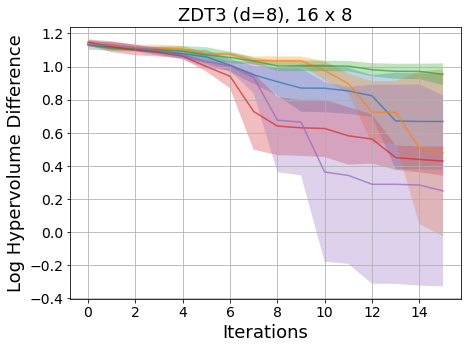

In [13]:
problemname = "ZDT3"
max_hv = 128.77549696900383

N_BATCH = 16
BATCH_SIZE = 8
N_TRIALS = 3

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

hvs_qnehvi, hvs_parallel_nsga, hvs_parallel_moead, hvs_hybrid_nsga, hvs_hybrid_moead = [], [], [], [], []

for algo_name, plot_name, hv_list, in zip(
    ['qnehvi', 'parallel_nsga', 'parallel_moead', 'hybrid_nsga', 'hybrid_moead'],
    ['Pure BO', 'Parallel w/ NSGA', 'Parallel w/ MOEAD', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD'],
    [hvs_qnehvi, hvs_parallel_nsga, hvs_parallel_moead, hvs_hybrid_nsga, hvs_hybrid_moead]):
    
    hv_list = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_plot = np.log10(max_hv - np.asarray(hv_list))

    ax.plot(np.arange(N_BATCH),
            hv_plot.mean(axis=0),
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    ax.fill_between(np.arange(N_BATCH),
                    hv_plot.mean(axis=0)-ci(hv_plot, N_TRIALS), hv_plot.mean(axis=0)+ci(hv_plot, N_TRIALS),
                    alpha=0.3)
    
ax.set(xlabel='Iterations')
ax.grid(True)
ax.set_title(f"{problemname} (d=8), {N_BATCH} x {BATCH_SIZE}", fontsize=18)
ax.set(ylabel='Log Hypervolume Difference')
#ax.legend(loc='lower left')

In [ ]:
handles,labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(2,2))
axi = fig_legend.add_subplot(111)            
fig_legend.legend(handles, labels, loc='center', scatterpoints = 1)
axi.xaxis.set_visible(False)
axi.yaxis.set_visible(False)
axi.axis("off")
fig_legend.canvas.draw()
fig_legend.show()

[Text(0, 0.5, 'Cumltv Hypervolume Wastage')]

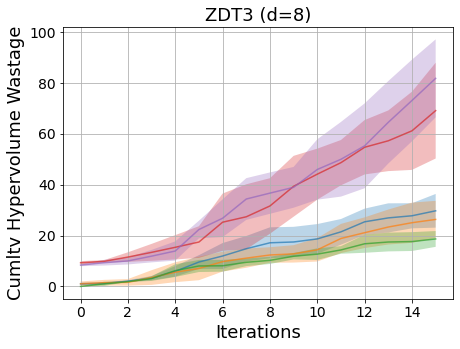

In [15]:
problem = Problem_ZDT3
problemname = "ZDT3"

N_BATCH = 16
BATCH_SIZE = 8
N_TRIALS = 3

ref_point = problem.ref_point
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

basedict = {}
a = 0
b = 2*(problem.n_var+1)-1
for i in range(0, N_BATCH+1):

    basedict[i] = (a, b)
    # a stays at zero
    b+=BATCH_SIZE
    
newdict = {}
a = 2*(problem.n_var+1)
b = 2*(problem.n_var+1)+BATCH_SIZE-1
for i in range(0, N_BATCH):

    newdict[i] = (a, b)
    a+=BATCH_SIZE
    b+=BATCH_SIZE
    
fig, ax = plt.subplots(1, 1, figsize=(7, 5))    
    
#waste_qnehvi, waste_parallel_nsga, waste_parallel_moead, waste_hybrid_nsga, waste_hybrid_moead = [], [], [], [], []

for algo_name, plot_name, in zip(
    ['qnehvi', 'parallel_nsga', 'parallel_moead', 'hybrid_nsga', 'hybrid_moead'],
    ['Pure BO', 'Parallel w/ NSGA', 'Parallel w/ MOEAD', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD']):
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj)

    hv_diff_list = []
    
    for trial in range(0, N_TRIALS):
        train_obj = torch.tensor(-train[trial][:,-problem.n_obj:], **tkwargs)
        hv_diff_inner_list = []
        
        placeholder = 0

        for i in range(0, N_BATCH):
                        
            base_obj = train_obj[basedict[i][0]:basedict[i][1]]
            pareto_mask = is_non_dominated(base_obj)
            pareto_y = base_obj[pareto_mask]
            base_volume = hv.compute(pareto_y)
            
            new_obj = train_obj[newdict[i][0]:newdict[i][1]]
            pareto_mask = is_non_dominated(new_obj)
            pareto_y = new_obj[pareto_mask]
            new_volume = hv.compute(pareto_y) 
                        
            hv_diff = base_volume - new_volume

            if hv_diff > 0:
                placeholder += hv_diff
                hv_diff_inner_list.append(placeholder)
            else:
                hv_diff_inner_list.append(placeholder) 
            
        hv_diff_list.append(hv_diff_inner_list)
        
    hv_diff_plot = np.asarray(hv_diff_list)

    ax.plot(np.arange(N_BATCH),
            hv_diff_plot.mean(axis=0),
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    ax.fill_between(np.arange(N_BATCH),
                    hv_diff_plot.mean(axis=0)-ci(hv_diff_plot, N_TRIALS), hv_diff_plot.mean(axis=0)+ci(hv_diff_plot, N_TRIALS),
                    alpha=0.3)
    
#ax.set_ylim(-0.5)

ax.set(xlabel='Iterations')
ax.grid(True)
ax.set_title(f"{problemname} (d=8)", fontsize=18)
ax.set(ylabel='Cumltv Hypervolume Wastage')
#ax.legend(loc='upper left')

Text(0.5, 1.0, 'PDF')

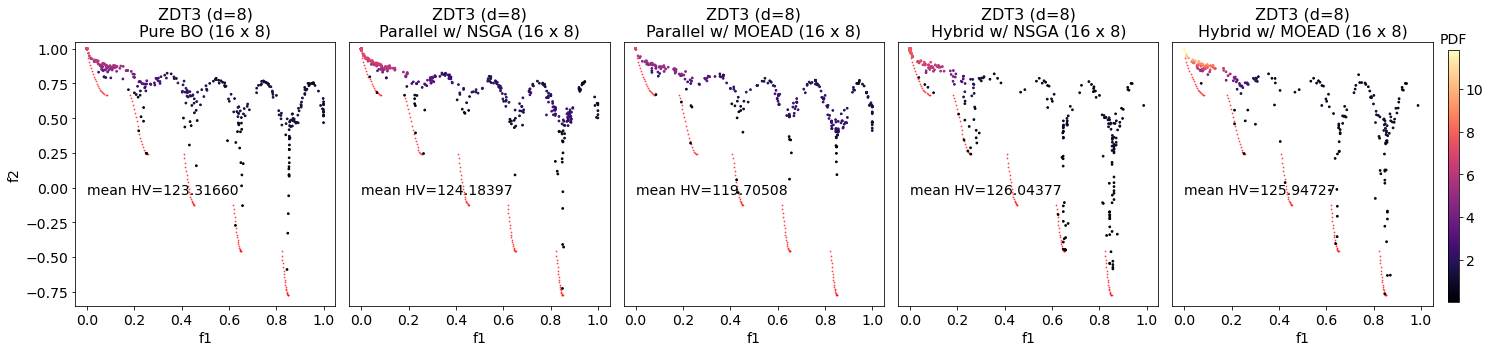

In [22]:
problemname = "ZDT3"
problem = Problem_ZDT3
problem1 = get_problem("zdt3")
pareto = problem1.pareto_front()    

N_TRIALS = 3
N_BATCH = 16
BATCH_SIZE = 8

hv_list, x_list, y_list, z_list = [], [], [], []

for algo_name in (['qnehvi', 'parallel_nsga', 'parallel_moead', 'hybrid_nsga', 'hybrid_moead']):
    
    hv = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_list.append(hv)
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj)
    
    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,problem.n_var:problem.n_var+problem.n_obj][:,0])
        ylist.append(-train[trial][:,problem.n_var:problem.n_var+problem.n_obj][:,1])

    x = np.array(xlist).reshape(-1)
    y = np.array(ylist).reshape(-1)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    
fig, ax = plt.subplots(ncols = 5, figsize = (21,5))

norm = plt.Normalize(np.array(z_list).min(), np.array(z_list).max())

for plot_name, i, in zip(
    ['Pure BO', 'Parallel w/ NSGA', 'Parallel w/ MOEAD', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD'],
    [0, 1, 2, 3, 4]):
    
    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=3, marker=".", alpha=0.6)

    ax[i].scatter(x_list[i], y_list[i], c=z_list[i], s=3, norm=norm, cmap='magma')
    
    ax[i].text(-0.0, -0.05, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"{problemname} (d={dimensions})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=16)

    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-0.85, 1.05)
    
    ax[i].set_xlabel('f1', fontsize=14)
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

    
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

ax[0].set_ylabel('f2', fontsize=14)

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)